In [ ]:
!python -m torch.distributed.launch --nproc_per_node=8 \
    --nnodes=1 --master_port=1234 main_finetune.py \
    --output_dir SatMAE/ \
    --batch_size 4 --accum_iter 4 \
    --model vit_large_patch16 --epochs 50 --blr 1e-3 --layer_decay 0.75 \
    --weight_decay 0.05 --drop_path 0.2 --reprob 0.25 \
    --mixup 0.8 --cutmix 1.0 --model_type temporal \
    --dist_eval --num_workers 8 --dataset temporal \
    --train_path  \
    --test_path 

/home/angelats11/.local/lib/python3.9/site-packages/torch/distributed/launch.py:181: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use-env is set by default in torchrun.
If your script expects `--local-rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
[2023-12-18 08:14:51,050] torch.distributed.run: [WARNING] 
[2023-12-18 08:14:51,050] torch.distributed.run: [WARNING] *****************************************
[2023-12-18 08:14:51,050] torch.distributed.run: [WARNING] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
[2023-12-18 08:14:51,050] torch.distributed.run: [WARNING] ****************************

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

# Define the path to your data folders
#orchard_path = "mountdata/euroorchardsSR"
#forest_path = "mountdata/euroforestsSR"

orchard_path = 'mountdata/zaforchardsSR'
forest_path = 'mountdata/zafforestsSR'

# Define hyperparameters
batch_size = 8
learning_rate = 0.001
num_epochs = 40

# Check if CUDA/GPU is available (optional but recommended for faster training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
anomalies = ['/content/mountdata/euroorchards2-50m/Image_00000000000000003009.tif',
             '/content/mountdata/euroorchards2-50m/Image_000000000000000078e4.tif',
             '/content/mountdata/euroorchards2-50m/Image_Lat_37.07623913852226_Lon_-2.000375028081088.tif', '/content/mountdata/euroorchards2-50m/Image_Lat_37.94822972682675_Lon_-3.4164829633312706.tif', '/content/mountdata/euroorchards2-50m/Image_Lat_38.8801773878959_Lon_-6.697988937774733.tif', '/content/mountdata/euroorchards2-50m/Image_Lat_38.95187527373425_Lon_-2.361976909808175.tif', '/content/mountdata/euroorchards2-50m/Image_Lat_39.193589764538395_Lon_-3.8118669946392627.tif', '/content/mountdata/euroorchards2-50m/Image_Lat_40.14078309210926_Lon_-5.999096193263948.tif', '/content/mountdata/euroorchards2-50m/Image_Lat_41.54885126816007_Lon_1.9003128004417624.tif', '/content/mountdata/euroorchards2-50m/Image_Lat_42.25991289944572_Lon_12.57314441725815.tif', '/content/mountdata/euroorchards2-50m/Image_Lat_42.43071430619691_Lon_11.15069564030997.tif', '/content/mountdata/euroorchards2-50m/Image_Lat_42.44744039424839_Lon_-7.791226743048059.tif', '/content/mountdata/euroforests2-50m/Image_00000000000000007414.tif', '/content/mountdata/euroforests2-50m/Image_0000000000000000777f.tif', '/content/mountdata/euroforests2-50m/Image_000000000000000077ab.tif', '/content/mountdata/euroforests2-50m/Image_Lat_38.984007555925395_Lon_-5.195878320506741.tif', '/content/mountdata/euroforests2-50m/Image_Lat_39.11165378268132_Lon_-5.202214703103686.tif', '/content/mountdata/euroforests2-50m/Image_Lat_39.203841237860274_Lon_-5.200292830549653.tif', '/content/mountdata/euroforests2-50m/Image_Lat_39.511327469202726_Lon_-6.671992378633144.tif', '/content/mountdata/euroforests2-50m/Image_Lat_39.64780717514556_Lon_-7.256049893714537.tif', '/content/mountdata/euroforests2-50m/Image_Lat_39.70667176815209_Lon_-6.175261898582432.tif', '/content/mountdata/euroforests2-50m/Image_Lat_39.718064771343656_Lon_-5.773746603325954.tif', '/content/mountdata/euroforests2-50m/Image_Lat_39.720976564331544_Lon_-6.417043275902375.tif', '/content/mountdata/euroforests2-50m/Image_Lat_42.11554950284041_Lon_-7.790700569123754.tif', '/content/mountdata/euroforests2-50m/Image_Lat_42.4521046139503_Lon_-8.770396284273188.tif', '/content/mountdata/euroforests2-50m/Image_Lat_42.452519310348265_Lon_-8.670079887873815.tif', '/content/mountdata/euroforests2-50m/Image_Lat_42.453041025171515_Lon_-8.469456013277178.tif']

anomalies = ['mountdata/zaforchards2-50m/Image_Lat_-22.240004789245813_Lon_29.037818903248997.tif', 'mountdata/zaforchards2-50m/Image_Lat_-23.190591509848193_Lon_30.02648230297659.tif', 'mountdata/zaforchards2-50m/Image_Lat_-23.206826468411446_Lon_30.02780007043587.tif', 'mountdata/zaforchards2-50m/Image_Lat_-23.729701304546758_Lon_30.581030198896638.tif', 
             'mountdata/zaforchards2-50m/Image_Lat_-23.75421204450379_Lon_30.040246170137554.tif', 'mountdata/zaforchards2-50m/Image_Lat_-24.36739322183993_Lon_30.740867775354953.tif', 'mountdata/zaforchards2-50m/Image_Lat_-24.36793308158871_Lon_30.78216057550199.tif', 'mountdata/zaforchards2-50m/Image_Lat_-24.36912426208262_Lon_30.70107562081649.tif', 
             'mountdata/zaforchards2-50m/Image_Lat_-24.369803520775992_Lon_30.706244153045976.tif', 
             'mountdata/zaforchards2-50m/Image_Lat_-24.369990509567586_Lon_30.697764023623456.tif', 'mountdata/zaforchards2-50m/Image_Lat_-25.004242898951123_Lon_31.056674929441822.tif', 'mountdata/zaforchards2-50m/Image_Lat_-25.083577710663594_Lon_31.059082643615447.tif', 'mountdata/zaforchards2-50m/Image_Lat_-25.355981316561753_Lon_30.87019654213516.tif', 
             'mountdata/zaforchards2-50m/Image_Lat_-25.356378638983212_Lon_30.749683721086058.tif', 'mountdata/zaforchards2-50m/Image_Lat_-25.399142856245106_Lon_31.853747261479064.tif', 'mountdata/zaforchards2-50m/Image_Lat_-25.42440065060146_Lon_31.10614799508328.tif', 'mountdata/zaforchards2-50m/Image_Lat_-32.15294327380358_Lon_18.886208968452273.tif', 
             'mountdata/zaforchards2-50m/Image_Lat_-32.266605173370685_Lon_18.979176591008986.tif', 'mountdata/zaforchards2-50m/Image_Lat_-32.80791159156275_Lon_18.7056015650465.tif', 'mountdata/zaforchards2-50m/Image_Lat_-33.424104508473484_Lon_19.219134895787988.tif', 'mountdata/zaforchards2-50m/Image_Lat_-33.42747627667723_Lon_25.494554865159728.tif', 
             'mountdata/zaforchards2-50m/Image_Lat_-33.76617526466205_Lon_23.486430250833436.tif', 'mountdata/zaforchards2-50m/Image_Lat_-33.81678984759524_Lon_23.75666510651492.tif', 'mountdata/zafforests2-50m/Image_Lat_-22.750359611743477_Lon_30.076954472051707.tif', 'mountdata/zafforests2-50m/Image_Lat_-24.893520791446683_Lon_31.057298004159495.tif', 'mountdata/zafforests2-50m/Image_Lat_-25.382506281880506_Lon_29.54393489111359.tif', 'mountdata/zafforests2-50m/Image_Lat_-25.38360708957488_Lon_29.41490838960512.tif', 
 'mountdata/zafforests2-50m/Image_Lat_-25.663925262990297_Lon_31.10501855033152.tif', 'mountdata/zafforests2-50m/Image_Lat_-26.299960611462208_Lon_25.683737847721723.tif', 'mountdata/zafforests2-50m/Image_Lat_-27.963598186452764_Lon_32.084100119337684.tif', 
             'mountdata/zafforests2-50m/Image_Lat_-28.315390968743124_Lon_32.45090360985396.tif', 'mountdata/zafforests2-50m/Image_Lat_-28.4597026176856_Lon_32.415726424788375.tif', 'mountdata/zafforests2-50m/Image_Lat_-28.937286098156267_Lon_30.947486221372245.tif', 'mountdata/zafforests2-50m/Image_Lat_-28.98745723719802_Lon_29.846632525779782.tif', 'mountdata/zafforests2-50m/Image_Lat_-29.803715878804166_Lon_30.26411985853742.tif', 'mountdata/zafforests2-50m/Image_Lat_-32.68005997185722_Lon_27.002089587012645.tif']

anoms = [x[9:] + '.npy' for x in anomalies]
print(anoms[0])

/zaforchards2-50m/Image_Lat_-22.240004789245813_Lon_29.037818903248997.tif.npy


In [3]:
dropout_prob = .2
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 39 * 39, 64)  # Adjusted for 156x156 input
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

class ComplexCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 19 * 19, 512)  # Adjusted for 156x156 input
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class LSTMCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(LSTMCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Recurrent layers
        self.lstm = nn.LSTM(128 * 50 * 50, 256, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Reshape for recurrent layer
        x = x.view(-1, 128 * 50 * 50)
        
        # Recurrent layer
        x, _ = self.lstm(x.unsqueeze(1))  # Add a temporal dimension
        
        # Global average pooling
        x = x.mean(dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

import torchvision.models as models

class SmallComplexModel(nn.Module):
    def __init__(self, num_classes=2):
        super(SmallComplexModel, self).__init__()
        
        # Load the pre-trained MobileNetV2 model
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        
        # Remove the classification head of MobileNetV2
        self.features = mobilenet_v2.features
        
        # Add custom layers for your task
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        # Feature extraction with MobileNetV2
        x = self.features(x)
        
        # Global average pooling
        x = self.avgpool(x)
        
        # Reshape for fully connected layer
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc(x)
        
        return x

# Create an instance of the model
#model = SmallComplexModel().to(device)

class ResModel(nn.Module):
    def __init__(self, num_classes=2):
        super(ResModel, self).__init__()
        
        # Load the pre-trained MobileNetV2 model
        resnet18 = models.resnet18(pretrained=True)
        
       # Remove the classification head of ResNet18
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Add custom layers for your task
#        self.fc = nn.Sequential(
#            nn.Flatten(),
#            nn.Linear(512, num_classes)
#        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),  # You can adjust the output size of the linear layer
            nn.ReLU(),           # Add activation function
            nn.Dropout(p=dropout_prob),  # Dropout layer
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        # Feature extraction with ResNet18
        x = self.features(x)

        # Fully connected layers
        x = self.fc(x)

        return x

model = ComplexCNN().to(device)
        

# Print the model architecture
#print(model)
# Instantiate the model
#complex_model = ComplexCNN().to(device)
#model = ComplexCNN().to(device)
# Instantiate the model
#complex_model = ComplexCNN().to(device)
#model = ComplexCNN().to(device)

In [4]:
shape = (160,160,3)

from torch.utils.data.sampler import SubsetRandomSampler

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = os.listdir(data_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.file_list[idx])
        if img_name in anoms:
          #return torch.zeros(50,50,3), -1
          return torch.zeros(160,160,3)
        image = np.squeeze(np.load(img_name, allow_pickle=True))
        #image = np.squeeze(np.load(img_name))[:,53:103,53:103]#.unsqueeze(0).unsqueeze(0)
        #print(image)
        #print(image.shape)
        #print(image)
        #if self.transform:
        #    image = self.transform(image)
        label = 0 if "orchard" in self.data_dir else 1  # Assuming "orchard" is class 0 and "forest" is class 1
        return image, label

# Data augmentation and normalization
transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create data loaders for training and validation
#orchard_dataset = CustomDataset(orchard_path, transform)
#forest_dataset = CustomDataset(forest_path, transform)
dataset = CustomDataset(orchard_path, transform) + CustomDataset(forest_path, transform)
split_ratio = 0.8
num_data = len(dataset)
split = int(np.floor(split_ratio * num_data))
indices = list(range(num_data))

indices = [idx for idx in indices if dataset[idx][1] != -1]

np.random.shuffle(indices)


# Create data samplers for training and testing sets
train_indices, test_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create data loaders for training and testing
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
# Use DataLoader to handle batching and shuffling
#orchard_loader = DataLoader(orchard_dataset, batch_size=batch_size, shuffle=True)
#forest_loader = DataLoader(forest_dataset, batch_size=batch_size, shuffle=True)

In [22]:
'''
import torch.nn as nn

class rgb50CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(rgb50CNN, self).__init__()
        # Define your model layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 64)  # Adjusted for 50x50 input
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)  # Ensure correct flattening
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Create an instance of the modified model
model = rgb50CNN().to(device)
'''

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
import torch.nn.functional as F
num_epochs = 30

def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    return total_loss / (batch + 1), train_accuracy

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * correct / total
    return total_loss / (batch + 1), val_accuracy


Epoch [1/30] - Train Loss: 0.6966, Train Acc: 49.19%, Val Loss: 0.6943, Val Acc: 47.50%
Epoch [2/30] - Train Loss: 0.6933, Train Acc: 50.62%, Val Loss: 0.6945, Val Acc: 47.50%
Epoch [3/30] - Train Loss: 0.6934, Train Acc: 50.62%, Val Loss: 0.6941, Val Acc: 47.50%
Epoch [4/30] - Train Loss: 0.6934, Train Acc: 50.62%, Val Loss: 0.6941, Val Acc: 47.50%
Epoch [5/30] - Train Loss: 0.6957, Train Acc: 48.88%, Val Loss: 0.6931, Val Acc: 52.25%
Epoch [6/30] - Train Loss: 0.6948, Train Acc: 49.06%, Val Loss: 0.7040, Val Acc: 46.75%
Epoch [7/30] - Train Loss: 0.6939, Train Acc: 49.31%, Val Loss: 0.7120, Val Acc: 47.00%
Epoch [8/30] - Train Loss: 0.7001, Train Acc: 50.25%, Val Loss: 0.6919, Val Acc: 53.00%
Epoch [9/30] - Train Loss: 0.7163, Train Acc: 50.19%, Val Loss: 0.7576, Val Acc: 47.00%
Epoch [10/30] - Train Loss: 0.6905, Train Acc: 50.31%, Val Loss: 0.7423, Val Acc: 46.75%
Epoch [11/30] - Train Loss: 0.6897, Train Acc: 50.94%, Val Loss: 0.7175, Val Acc: 47.50%
Epoch [12/30] - Train Loss: 0.

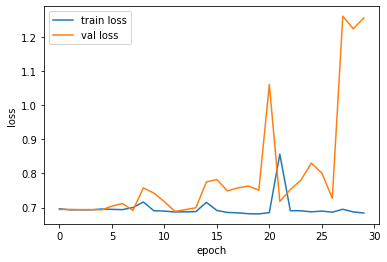

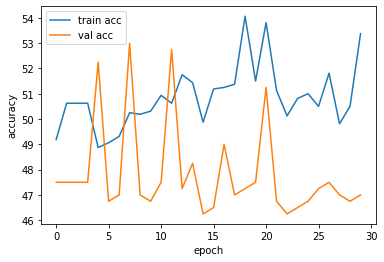

In [7]:

# ... (optimizer and criterion)

# Training loop with validation
trnl = []
vall = []
trna=[]
vala=[]
epochs = [x for x in range(num_epochs)]
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy = validate(model, test_loader, criterion)
    trnl.append(train_loss)
    vall.append(val_loss)
    trna.append(train_accuracy)
    vala.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trnl,label='train loss')
plt.plot(epochs,vall,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,[.6092,.449,.434,.419,.391,.352,.344,.336,.312,.3025..2889,.2897,.2453,.1765,.2205,.1512,.1386,.11,.119,.1312,.1498,.0649,.0554,.1836,.122,.0397,.0664,.0945,.017,.0257,.0834],label='train loss')
plt.plot(epochs,[5.495],label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Epoch [1/40] - Train Loss: 0.6092, Train Acc: 69.81%, Val Loss: 5.4950, Val Acc: 51.25%
Epoch [2/40] - Train Loss: 0.4494, Train Acc: 80.19%, Val Loss: 0.9689, Val Acc: 51.75%
Epoch [3/40] - Train Loss: 0.4338, Train Acc: 81.31%, Val Loss: 0.7091, Val Acc: 56.75%
Epoch [4/40] - Train Loss: 0.4194, Train Acc: 82.94%, Val Loss: 0.5580, Val Acc: 66.75%
Epoch [5/40] - Train Loss: 0.3908, Train Acc: 83.88%, Val Loss: 0.5131, Val Acc: 70.75%
Epoch [6/40] - Train Loss: 0.3520, Train Acc: 85.19%, Val Loss: 0.5214, Val Acc: 67.75%
Epoch [7/40] - Train Loss: 0.3439, Train Acc: 85.19%, Val Loss: 0.5764, Val Acc: 71.50%
Epoch [8/40] - Train Loss: 0.3358, Train Acc: 87.94%, Val Loss: 1.4960, Val Acc: 51.50%
Epoch [9/40] - Train Loss: 0.3119, Train Acc: 86.81%, Val Loss: 1.0391, Val Acc: 64.00%
Epoch [10/40] - Train Loss: 0.3025, Train Acc: 87.81%, Val Loss: 0.9148, Val Acc: 73.00%
Epoch [11/40] - Train Loss: 0.2889, Train Acc: 88.69%, Val Loss: 0.6353, Val Acc: 58.25%
Epoch [12/40] - Train Loss: 0.

Training complete.


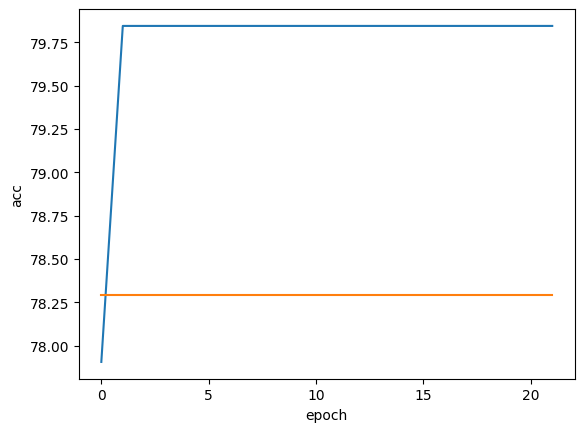

In [ ]:
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot([x for x in range(22)],trna,label='train loss')
plt.plot([x for x in range(22)],vala,label='val loss')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

In [ ]:
model.train(train_loader)

ValueError: ignored

NEXT: THE PART WHERE WE TRAIN ON SENTINEL-2 ALONE AS A BENCHMARK (BOTTOM TIE PERFOMANCE TO BEAT)


In [5]:
#orchard_path = "mountdata/euroorchards2-50m"
#forest_path = "mountdata/euroforests2-50m"

orchard_path = 'mountdata/zaforchards2-50m'
forest_path = 'mountdata/zafforests2-50m'

In [10]:
#import tifffile
from PIL import Image
import rasterio as rio

#import cv2
#import gdal
from torch.utils.data.sampler import SubsetRandomSampler
#import imagecodecs
from skimage import io

anomalies = []
class CustomDatasetS2(Dataset):
    def __init__(self, data_dir, transform=None, num_channel=12):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = os.listdir(data_dir)
        self.num_channel = num_channel

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.file_list[idx])
        if img_name.endswith('.tif'):
            if img_name in anomalies:
                pass
            with rio.open(img_name) as img :
                image= img.read()
                image = image.astype('float32')
    
                image = image[:self.num_channel,2:52,2:52]
                image = np.transpose(image,(1,2,0))
                #print
                if image.shape != (50,50,self.num_channel):
                    print('anomaly')
                    anomalies.append(img_name)
                    return torch.zeros(50, 50,self.num_channel), -1
                    #return torch.zeros(10, 10,12), -1
                
                if self.transform:
                    image = self.transform(image)
            label = 0 if "orchard" in self.data_dir else 1  # Assuming "orchard" is class 0 and "forest" is class 1
            return image, label

transform = transforms.Compose([transforms.ToTensor()])
bicubtransform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((160, 160), interpolation=Image.BICUBIC), transforms.ToTensor()])

datasets2 = CustomDatasetS2(orchard_path, transform, 3) + CustomDatasetS2(forest_path, transform, 3)
split_ratio = 0.8
num_data = len(datasets2)
split = int(np.floor(split_ratio * num_data))
indices = list(range(num_data))
indices = [idx for idx in indices if datasets2[idx][1] != -1]
np.random.shuffle(indices)


# Create data samplers for training and testing sets
train_indices, test_indices = indices[:split], indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create data loaders for training and testing
train_loader = DataLoader(datasets2, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(datasets2, batch_size=batch_size, sampler=test_sampler)

print(anomalies)

anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
anomaly
['mountdata/zaforchards2-50m/Image_Lat_-22.240004789245813_Lon_29.037818903248997.tif', 'mountdata/zaforchards2-50m/Image_Lat_-23.190591509848193_Lon_30.02648230297659.tif', 'mountdata/zaforchards2-50m/Image_Lat_-23.206826468411446_Lon_30.02780007043587.tif', 'mountdata/zaforchards2-50m/Image_Lat_-23.729701304546758_Lon_30.581030198896638.tif', 'mountdata/zaforchards2-50m/Image_Lat_-23.75421204450379_Lon_30.040246170137554.tif', 'mountdata/zaforchards2-50m/Image_Lat_-24.36739322183993_Lon_30.740867775354953.tif', 'mountdata/zaforchards2-50m/Image_Lat_-24.36793308158871_Lon_30.78216057550199.tif', 'mountdata/zaforchards2-50m/Image_Lat_-24.36912426208262_Lon_30.70107562081649.tif', 'mountdata/zaforchards2

In [38]:
#input_size = (3, 50, 50)  # Assuming 3 channels, 160x160 size
#dummy_input = torch.randn(1, *input_size).to(device)  # Create a dummy input
#output = model(dummy_input)

Epoch [1/40] - Train Loss: 0.5812, Train Acc: 73.56%, Val Loss: 0.5142, Val Acc: 70.05%
Epoch [2/40] - Train Loss: 0.4515, Train Acc: 79.62%, Val Loss: 0.4363, Val Acc: 78.30%
Epoch [3/40] - Train Loss: 0.4038, Train Acc: 83.94%, Val Loss: 0.4490, Val Acc: 75.55%
Epoch [4/40] - Train Loss: 0.4361, Train Acc: 80.62%, Val Loss: 0.3786, Val Acc: 83.52%
Epoch [5/40] - Train Loss: 0.3922, Train Acc: 84.44%, Val Loss: 0.7166, Val Acc: 69.51%
Epoch [6/40] - Train Loss: 0.4439, Train Acc: 82.19%, Val Loss: 0.9186, Val Acc: 63.46%
Epoch [7/40] - Train Loss: 0.4009, Train Acc: 84.25%, Val Loss: 0.3939, Val Acc: 83.24%
Epoch [8/40] - Train Loss: 0.3540, Train Acc: 87.06%, Val Loss: 0.4481, Val Acc: 82.14%
Epoch [9/40] - Train Loss: 0.3459, Train Acc: 87.62%, Val Loss: 0.3713, Val Acc: 84.62%
Epoch [10/40] - Train Loss: 0.2969, Train Acc: 88.62%, Val Loss: 0.4520, Val Acc: 78.30%
Epoch [11/40] - Train Loss: 0.2536, Train Acc: 90.44%, Val Loss: 0.4226, Val Acc: 80.49%
Epoch [12/40] - Train Loss: 0.

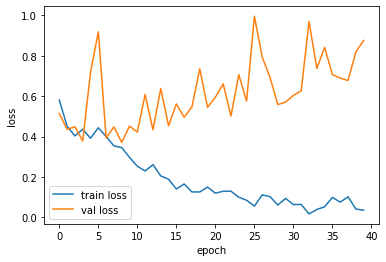

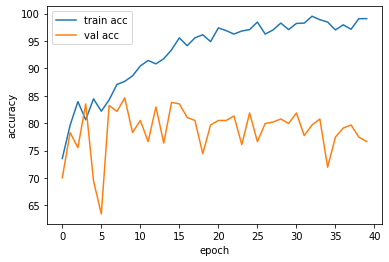

In [11]:
import rasterio as rio
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop with validation
trnl = []
vall = []
trna=[]
vala=[]
epochs = [x for x in range(num_epochs)]
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy = validate(model, test_loader, criterion)
    trnl.append(train_loss)
    vall.append(val_loss)
    trna.append(train_accuracy)
    vala.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trnl,label='train loss')
plt.plot(epochs,vall,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Training complete.


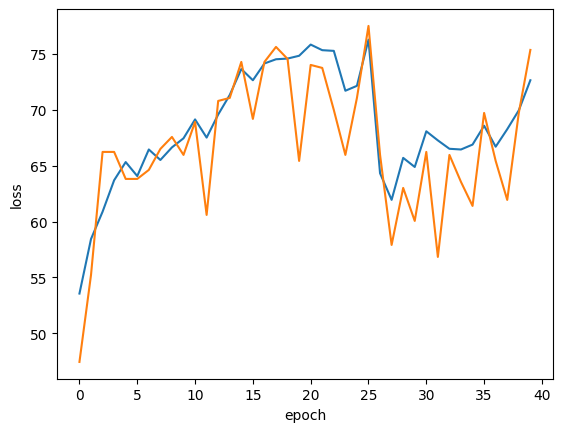

In [14]:
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trna,label='train loss')
plt.plot(epochs,vala,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Training complete.


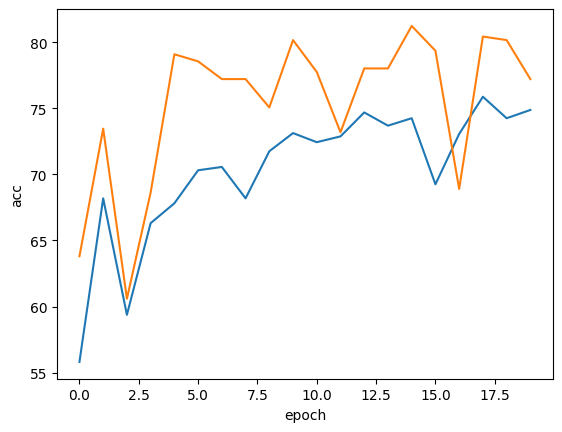

In [ ]:
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot([x for x in range(20)],trna,label='train loss')
plt.plot([x for x in range(20)],vala,label='val loss')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [11]:
# Convert the NumPy array to a NumPy array with data type 'uint8'

class CustomDatasetS2(Dataset):
    def __init__(self, data_dir, transform=None, num_channel=12):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = os.listdir(data_dir)
        self.num_channel = num_channel

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.file_list[idx])
        if img_name.endswith('.tif'):
            if img_name in anomalies:
                pass
            with rio.open(img_name) as img :
                image= img.read()
                image = image.astype('float32')
                image = (image * 255).astype('uint8')
                image = image[:self.num_channel,2:52,2:52]
                image = np.transpose(image,(1,2,0))
                #print
                if image.shape != (50,50,self.num_channel):
                    print('anomaly')
                    anomalies.append(img_name)
                    return torch.zeros(50, 50,self.num_channel), -1
                    #return torch.zeros(10, 10,12), -1
                
                if self.transform:
                    image = self.transform(image)
            label = 0 if "orchard" in self.data_dir else 1  # Assuming "orchard" is class 0 and "forest" is class 1
            return image, label


/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/angelats11/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/40] - Train Loss: 0.6658, Train Acc: 64.62%, Val Loss: 1.3218, Val Acc: 69.51%
Epoch [2/40] - Train Loss: 0.6147, Train Acc: 69.50%, Val Loss: 0.5802, Val Acc: 73.90%
Epoch [3/40] - Train Loss: 0.5670, Train Acc: 71.25%, Val Loss: 0.4923, Val Acc: 78.57%
Epoch [4/40] - Train Loss: 0.5217, Train Acc: 76.06%, Val Loss: 0.4539, Val Acc: 79.67%
Epoch [5/40] - Train Loss: 0.4644, Train Acc: 79.94%, Val Loss: 0.5339, Val Acc: 70.60%
Epoch [6/40] - Train Loss: 0.4429, Train Acc: 80.38%, Val Loss: 0.4838, Val Acc: 76.37%
Epoch [7/40] - Train Loss: 0.4164, Train Acc: 82.19%, Val Loss: 0.4225, Val Acc: 81.87%
Epoch [8/40] - Train Loss: 0.4278, Train Acc: 82.06%, Val Loss: 0.4568, Val Acc: 77.47%
Epoch [9/40] - Train Loss: 0.3810, Train Acc: 83.38%, Val Loss: 0.4908, Val Acc: 79.67%
Epoch [10/40] - Train Loss: 0.3441, Train Acc: 84.94%, Val Loss: 0.6013, Val Acc: 74.45%
Epoch [11/40] - Train Loss: 0.2808, Train Acc: 89.06%, Val Loss: 0.6107, Val Acc: 73.90%
Epoch [12/40] - Train Loss: 0.

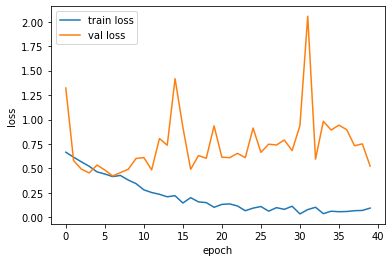

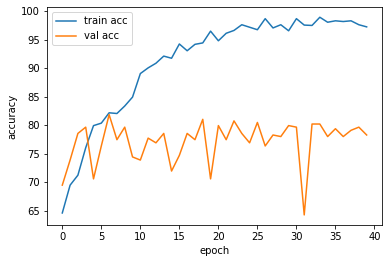

In [12]:
num_epochs = 40
datasets2bicub = CustomDatasetS2(orchard_path, bicubtransform, 3) + CustomDatasetS2(forest_path, bicubtransform, 3)

# Create data loaders for training and testing
train_loader = DataLoader(datasets2bicub, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(datasets2bicub, batch_size=batch_size, sampler=test_sampler)

model = ResModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Training loop with validation
trnl = []
vall = []
trna=[]
vala=[]
epochs = [x for x in range(num_epochs)]
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy = validate(model, test_loader, criterion)
    trnl.append(train_loss)
    vall.append(val_loss)
    trna.append(train_accuracy)
    vala.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trnl,label='train loss')
plt.plot(epochs,vall,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
print("Training complete.")
import matplotlib.pyplot as plt
plt.plot(epochs,trnl,label='train loss')
plt.plot(epochs,vall,label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(epochs,trna,label='train acc')
plt.plot(epochs,vala,label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()